### Investing some 1D cases

In [6]:
%matplotlib inline

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### ADT

In [3]:
adt_data = pd.read_csv('/ye/yelabstore2/mincheol/data/scrna-parameter-estimation/raw/adt.csv')

In [34]:
adt_data.columns

Index(['CD14', 'CD19', 'CD45', 'CD4', 'CD8A'], dtype='object')

In [122]:
cd8a_adt = adt_data['CD8A']
# cd45 = cd45[cd45 < 1000]

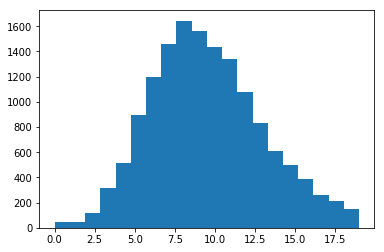

In [124]:
plt.hist(cd8a_adt[cd8a_adt < 20], bins=20);

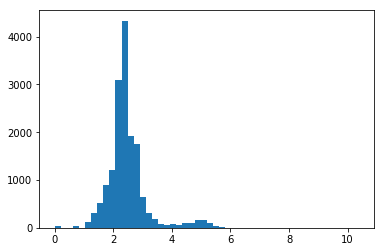

In [153]:
plt.hist(np.log(cd8a_adt + 1), bins=50);

### mRNA

In [126]:
transcript_data = pd.read_csv('/ye/yelabstore2/mincheol/data/scrna-parameter-estimation/raw/mrna.csv')

In [136]:
cd8a_mrna = transcript_data['CD8A']

In [137]:
cd8a_mrna.value_counts()

0    11442
1      927
2      237
3       65
4        9
5        2
6        1
9        1
Name: CD8A, dtype: int64

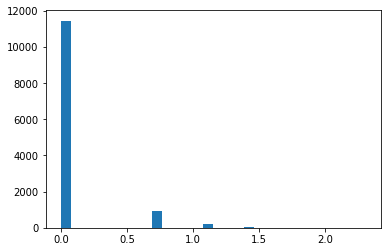

In [152]:
plt.hist(np.log(cd8a_mrna+1), bins=30);

### Simulation

Lets say the underlying distribution is mean 10 with variance 2.

In [146]:
sim_truth = np.random.normal(5, 2, size=10000)

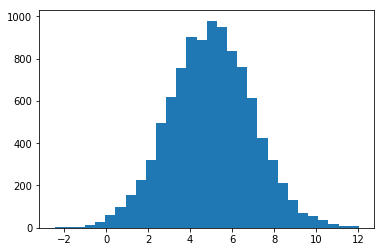

In [147]:
plt.hist(sim_truth, bins=30);

In [149]:
observed = []
for cell in sim_truth[sim_truth >=0]:
    observed.append(np.random.binomial(int(cell), 0.15))
observed = np.array(observed)

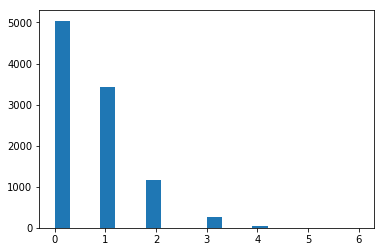

In [155]:
plt.hist(observed, bins=20);